# <span style="color:blue">Please upvote the kernel if you like, it will really be appreciated.</span>

In [ ]:
import os
import math

import json
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotnine import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import folium
import folium.plugins
import branca.colormap as cm

import geopandas as gpd


import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import clear_output


# color pallette
c = '#393e46' # confirmed - grey
d = '#ff2e63' # death - red
r = '#30e3ca' # recovered - cyan
i = '#f8b400' # still infected - yellow
mr = '#ed001c' # mortality rate - red2
rr = '#0cf0af' # Recovery rate - cyan2
si = '#f8e300' # Still infected coverage - yellow2
ic = '#8698b5' # Infection coverage - grey2

cdr = [c, d, r] 
idr = [i, d, r] 
rid = [r, i, d]

valid_case_columns = {'Deaths': d, 'Recovered': r, 'Still Infected': i,  'Confirmed': c}
valid_mortality_columns = {'Infection coverage': ic, 'Still infected coverage': si, 'Mortality rate': mr,  'Recovery rate': rr}

# world boundries
wd_geo_data_path = os.path.join('/kaggle/input/python-folio-country-boundaries', "world-countries.json")
# china boundaries
# ch_geo_data_path = os.path.join('/kaggle/input/china-regions-map', "china-provinces.json")
ch_geo_data_path = os.path.join('/kaggle/input/china-province-geojson', "gadm36_CHN_1.json")

In [ ]:
# *** utility functions ***

# --- dataframe manipulation functions ----
def handle_age(df):
    """Extract correct age information from dataframe.

    Args:
        df (dataframe): Dataframe for extracting age information.

    Returns:
        numeric_age_bins_vc (dataframe): Bins of ages with corresponding frequency.
    """
    # first,drop nan rows in age column
    df_c = df.dropna(subset=['age'])
    # then get numeric age values from string age column and convert them to int
    numeric_age = pd.to_numeric(df_c['age'], errors='coerce').dropna().astype(np.int64)
    # make numeric age values binning to ranges
    highest_tenth = int(10 * math.ceil(float(max(numeric_age))/10))
    labels = ["{0}-{1}".format(i, i + 9) for i in range(0, highest_tenth, 10)]
    numeric_age_bins = pd.cut(x=numeric_age, bins=range(0, highest_tenth+10, 10), right=False, labels=labels)
    numeric_age_bins_vc = numeric_age_bins.value_counts()
    # eliminate already processed values (age values succesfully converted to int)
    unproceeed_ages = df_c[~df_c.index.isin(numeric_age.index)]['age'].value_counts()
    for i, v in unproceeed_ages.items():
        if i in numeric_age_bins_vc.index:
            numeric_age_bins_vc.loc[i] += v

    return numeric_age_bins_vc

def add_additional_cols(df, col_list=None):
    """Add additional predefined columns to given dataframe.

    Args:
        df (dataframe): Dataframe for applying trasnformation.
        col_list (list): Subset of predefined columns for selection. If None, add all columns.

    Returns:
        df (dataframe): Modified dataframe after transformation.
    """
    valid_col_list = []
    if col_list is None or 'Still Infected' in col_list:
        df['Still Infected'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        valid_col_list.append('Still Infected')
    if col_list is None or 'Infection coverage' in col_list:
        df['Infection coverage'] = round((df['Confirmed'] / df['Population'])*1000000, 3)
        valid_col_list.append('Infection coverage')
    if col_list is None or 'Still infected coverage' in col_list:
        df['Still infected coverage'] = round((df['Still Infected'] / df['Population'])*1000000, 3)
        valid_col_list.append('Still infected coverage')
    if col_list is None or 'Mortality rate' in col_list:
        df['Mortality rate'] = round((df['Deaths'] / df['Confirmed'])*100, 3)
        valid_col_list.append('Mortality rate')
    if col_list is None or 'Recovery rate' in col_list:
        df['Recovery rate'] = round((df['Recovered'] / df['Confirmed'])*100, 3)
        valid_col_list.append('Recovery rate')
    
    if valid_col_list:
        df[valid_col_list] = df[valid_col_list].fillna(0)

    
    return df

def transform_data(data, transform_type):
    """Apply given trasnformation to given data.

    Args:
        data (dataframe): Dataframe for applying trasnformation.
        transform_type (string): Name of the trasnformation will be applied.

    Returns:
        - (dataframe): Trasnformed data.
    """
    if transform_type == 'none':
        return data
    elif transform_type == 'ln':
        return np.log10((data + 1))
    elif transform_type == 'log10':
        return np.log10((data + 1))
    elif transform_type == 'square root':
        return np.sqrt(data)
    elif transform_type == 'cubic root':
        return np.cbrt(data)
    elif transform_type == 'boxcox':
        return sc.stats.boxcox(data + 1)[0]
    else:
        raise ValueError('Unknown trasnformation argument has been given')

# --- plotting functions ---
def find_factor_of(latest_df, full_df, column, factor, lower_threshold=0, limit=None):
    """Find the past record of given column that the latest record is a factor of this record.

    Args:
        latest_df (dataframe): Dataframe only includes latest records of countries.
        full_df (dataframe): Dataframe includes all dates and countries.
        column (string): Name of the column the processing on ex: 'Confirmed', 'Deaths'.
        factor (float): A float given as a factor ex: 2, 3, 4.
        lower_threshold (float): Minimum number of occurences at the latest date.
        limit (int): Number of rows that return only n shortest span of countries.

    Returns:
        - (dataframe): Trasnformed data.
    """
    def find_past_factor_date(df):
        df = df[(0 < df[column]) & (df[column] <= float(df.loc[df['Date'].idxmax()][column]/factor))]
        return df.sort_values('Date', ascending=False).head(1)
    
    date_c_name, count_c_name, difference_c_name, factor_c_name = 'Date since', 'Count on this date',\
                                                                  'Number of days', 'Factor of'
    factor_df = latest_df.copy()
    factor_df = factor_df[factor_df[column] > max(factor-1, lower_threshold)]
    full_df_valid_rows = full_df[full_df['Country/Region'].isin(factor_df['Country/Region'])].groupby(['Country/Region', 'Date']).agg({column:sum}).reset_index()
    factor_df = factor_df.set_index('Country/Region', drop=True)
    factor_df[[date_c_name, count_c_name]] = full_df_valid_rows.groupby(['Country/Region']).apply(find_past_factor_date).set_index('Country/Region', drop=True)
    factor_df[difference_c_name] = (factor_df['Date'] - factor_df[date_c_name]).dt.days
    factor_df[factor_c_name] = (factor_df[column] / factor_df[count_c_name]).round(2)
    factor_df[date_c_name] = factor_df[date_c_name].dt.strftime('%Y-%m-%d')
    factor_df = factor_df.sort_values([difference_c_name, factor_c_name], ascending=[True, False]).reset_index()
    factor_df=factor_df.rename(columns={column: 'Count now'})
    

    if limit:
        factor_df = factor_df.head(limit)
    
    return factor_df, date_c_name, count_c_name, difference_c_name, factor_c_name
    
def display_tabular_df(df, columns=None, sort_col=None, cmap='Reds'):
    """Display dataframe in tabular format.

    Args:
        df (dataframe): Dataframe for creating choropleth layer.
        columns (list): List of dataframe columns to select subset of them.
        sort_col (string): Name of column rows will be sorted.
        cmap (string): Name of color map will be used ing tabular form.

    Returns:
        No return values given.
    """
    
    if not df.empty:
        if columns is None:
            columns = df.columns
        
        temp = df[columns]
        
        if sort_col and sort_col in df.columns:
            temp = temp.sort_values(sort_col, ascending=False)
        
        display(temp.style.background_gradient(cmap=cmap).hide_index() \
        .set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt'),('border-style','solid'),('border-width','1px')]}, 
                           {'selector': 'td', 'props': [('font-size', '10pt'),('border-style','solid'),('border-width','1px')]}]))
    else:
        print('No country has been found.')

def plotly_bar_plot(df_list, x_column_dicts, y_columns, subplot_titles, title=None, rows=1, cols=2, height=1000, v_space=0.05, h_space=0.1, 
                    custom_data_list=None, is_stacked=True, transformation='log10'):
    """Create a plotly bar graph figure with subplots.

    Args:
        df_list (list): List of dataframes for creating each subplot.
        x_column_dicts (list): List of dicts including column names of dataframe for each subplot with corresponding colorbrewer palette.
        y_columns (list): List of columns for y-axis per subplot.
        subplot_titles (list): List of titles one per subplot.
        title (str): Figure title.
        rows (int): Number of rows for making subplot.
        cols (int): Number of columns for making subplot.
        height (int): Height of complete figure.
        v_space (float): Vertical spacing for subplots.
        h_space (float): Horizontal spacing for subplots.
        custom_data_list (list): List of dataframe used as custom data in subplots.
        is_stacked (bool): Whether the bar subplots will be stacked.
        transformation (str): Type of the transformation will be applied on x-axis.

    Returns:
        fig (Plotly figure): A Plotly figure includes several subplots.
    """
    fig = make_subplots(rows=rows, cols=cols, shared_xaxes=False, subplot_titles=subplot_titles, vertical_spacing=v_space, horizontal_spacing=h_space)
    
    if custom_data_list is None:
        custom_data_list = [None]*len(df_list)
        
    for index, (df, x_column_dict, y_column, custom_data) in enumerate(zip(df_list, x_column_dicts, y_columns, custom_data_list)):
        if custom_data is None:
            custom_data = df
        
        row_number = math.floor(index / cols) + 1
        col_number = (index % cols) + 1
        for col, color in x_column_dict.items():
            transformed_data = transform_data(df[col], transformation)
            fig.add_trace(go.Bar(x=transformed_data, 
                          y=df[y_column],
                          text=[col] * len(transformed_data),
                          name=f'{col}',
                          marker_color=color,
                          customdata=custom_data[col],
                          hovertemplate='%{y}-%{text}: %{customdata}',
                          orientation='h'), row=row_number, col=col_number)

    layout = {"showlegend": True,'height': height}
    if is_stacked:
        layout['barmode'] = 'stack'
    
    if title:
        layout['title'] = title
    
    fig.update_layout(layout)

    return fig

def plotly_scatter_plot(df_list, x_columns, y_columns_list, subplot_titles, title=None, rows=1, cols=2, height=1000, v_space=0.05, h_space=0.1, custom_data_list=None, transformation='none'):
    """Create a plotly scatter graph figure with subplots.

    Args:
        df_list (list): List of dataframes for creating each subplot.
        x_columns (list): List of columns for x-axis per subplot.
        y_columns_list (list): List of lists including column names of dataframe for each subplot with corresponding colorbrewer palette.
        subplot_titles (list): List of titles one per subplot.
        title (str): Figure title.
        rows (int): Number of rows for making subplot.
        cols (int): Number of columns for making subplot.
        height (int): Height of complete figure.
        v_space (float): Vertical spacing for subplots.
        h_space (float): Horizontal spacing for subplots.
        custom_data_list (list): List of dataframe used as custom data in subplots.
        transformation (str): Type of the transformation will be applied on x-axis.

    Returns:
        fig (Plotly figure): A Plotly figure includes several subplots.
    """
    fig = make_subplots(rows=rows, cols=cols, shared_xaxes=False, subplot_titles=subplot_titles, vertical_spacing=v_space, horizontal_spacing=h_space)
    
    if custom_data_list is None:
        custom_data_list = [None]*len(df_list)
        
    for index, (df, x_column, y_columns, custom_data) in enumerate(zip(df_list, x_columns, y_columns_list, custom_data_list)):
        if custom_data is None:
            custom_data = df
        
        row_number = math.floor(index / cols) + 1
        col_number = (index % cols) + 1
        for col in y_columns:
            transformed_data = transform_data(df[col], transformation)
            fig.add_trace(go.Scatter(x=df[x_column],
                          y=transformed_data,
                          text=[col] * len(transformed_data),
                          name=f'{col}',
                          marker=dict(color=df[col], coloraxis="coloraxis"),
                          customdata=custom_data[col],
                          hovertemplate='%{x}-%{text}: %{customdata}',), row=row_number, col=col_number)

    layout = {"showlegend": True,'height': height}
    if title:
        layout['title'] = title
    
    fig.update_layout(layout)

    return fig


def plotly_graph(df, geojson_path=wd_geo_data_path, key_col_dict=None):
    """Create a plotly multilayer choropleth map.

    Args:
        df (dataframe): Dataframe for creating choropleth layer.
        geojson_path (os.path): File path of related geojson file.
        key_col_dict (dict): Dict including column names of dataframe for choropleth visualization with corresponding colorbrewer palette.

    Returns:
        base_map (Folium map): Modified map.
    """
    # read geojson file for map
    with open(geojson_path) as f:
        geojson_file = json.load(f)
    
    # variables for map creation
    fill_opacity = 0.7
    
    data, dropdown_list = [], []

    for index, (col_name, palette) in enumerate(key_col_dict.items()):
        data.append(go.Choroplethmapbox(geojson=geojson_file,
                                        name=col_name,
                                        locations=df['Country/Region'],
                                        featureidkey='properties.name',
                                        z=np.log10(df[col_name]),
                                        visible=False,
                                        marker_opacity=fill_opacity,
                                        text=df['Country/Region'],
                                        customdata=df[col_name],
                                        hovertemplate='<br>Country: %{text}' +
                                                      '<br>Cases: %{customdata}' +
                                                      '<br>Log10 (cases): %{z}',
                                        colorbar=dict(title=f'{col_name} cases (log10 scale)', tickprefix='10^'),
                                        colorscale=palette
                                            ))
        visibility_pattern = [False] * (len(key_col_dict))
        visibility_pattern[index] = True
        dropdown_list.append(dict(
                        args=['visible', visibility_pattern],
                        label=f'{col_name} cases',
                        method='restyle'
                    ),)
    
    data[0]['visible'] = True
    
    layout=go.Layout(mapbox_style="carto-positron",
                     mapbox_zoom=1,
                     width=1800,
                     height=800)
    
    #dropdown code from https://plot.ly/~empet/15237/choroplethmapbox-with-dropdown-menu/#/
    layout.update(updatemenus=list([
            dict(x=0.5, y=1,
                xanchor="center",
                yanchor='bottom',
                buttons=dropdown_list)]))
    
    # layout.update(margin={"r":0,"t":0,"l":0,"b":0})
    fig = go.Figure(data=data,layout=layout)
    
    return fig

def create_choropleth(base_map, data, key_col_name, merge_column, palette, transformation, is_active=False):
    """Helper function to create a folium choropleth layer and add to base map.

    Args:
        base_map (Folium map): Initial map.
        data (dataframe): Dataframe for creating choropleth layer.
        key_col_name (str): Name of the column will be used for coloring of this layer.
        merge_column (str): Name of the column has been used for grouping the dataframe (country or province).
        palette (str): Name of the colorbrewer palette.
        transformation(string): In which transformation will be applied to data for visualization.
        is_active (bool): Whether this layer will be shown initially.

    Returns:
        base_map (Folium map): Modified map.
    """
    color_palette = getattr(cm.linear, palette)
    # apply square root data normalization
    transformed_data = transform_data(data[key_col_name], transformation)
    colormap = color_palette.to_step(n=9, data=(transformed_data))    
    colormap.caption = f"{key_col_name} cases ({transformation})"
    
    # styling options
    style_function = lambda feature: {"weight":0.5, 
                                      'color':'black',
                                      'fillColor':colormap(feature['properties'][key_col_name]), 
                                      'fillOpacity':0.5}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    geo_layer=folium.features.GeoJson(
            data,
            style_function=style_function,
            name=f"{key_col_name} cases",
            overlay=True,
            show=is_active,
            highlight_function=highlight_function,
            tooltip=folium.features.GeoJsonTooltip(fields=[merge_column, key_col_name],
                aliases=[f'{merge_column}',f"{key_col_name} cases"],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
                sticky=True
            )
        )
    colormap.add_to(base_map)
    base_map.add_child(geo_layer)
    
    return base_map

def marker_cluster_with_choropleth(data, marker_col_list, key_col_dict=None, geojson_path=wd_geo_data_path, 
                                   gdp_merge_column='Country/Region', gpd_column='name', transformation='log10'):
    """Create a folium map with marker cluster and optional choropleth layers.

    Args:
        data (dataframe): Dataframe for creating vizualization.
        key_col_dict (dict): Dict including column names of dataframe for choropleth visualization with corresponding colorbrewer palette.
        marker_col_list (list): List of the columns used for marker points visualization.
        geojson_path (os.path): File path of related geojson file.
        gdp_merge_column(string): In which column of original dataframe will be used to merge with geopandas dataframe.
        gpd_column(string): In which column of geopandas dataframe will be used for dataframe merge to get the geometry.
        transformation(string): In which transformation will be applied to data for visualization.

    Returns:
        m (Folium map): Created map.
    """
    # variables for map creation
    radius_min = 5
    radius_max = 100
    weight = 1
    fill_opacity = 0.5
    color = 'red'
    
    # read related geopandas dataframe from path and select related columns
    geopandas_df = gpd.read_file(geojson_path)[[gpd_column, 'geometry']]
    #print(geopandas_df)
    #print(data[gdp_merge_column])
    
    
    # calculate center of the given map
    x_map=geopandas_df.centroid.x.mean()
    y_map=geopandas_df.centroid.y.mean()
    
    # set a base map
    m = folium.Map(location=[x_map, y_map], zoom_start=2, tiles='CartoDB positron', control=False)
    
    # iterate over each key columns with palette to create choropleth layers if not none
    # make active only one chropleth layer to avoid overlayying all layers
    if key_col_dict is not None:
        # groupby given dataframe by given merger column because choropleth layers give higher level of overview.
        valid_col_list = list(key_col_dict.keys()) + [gdp_merge_column]
        choropleth_df = data.groupby(gdp_merge_column)[valid_col_list].sum().reset_index()
        # merge geopandas dataframe with original one to create full geopandas dataframe
        choropleth_df = geopandas_df.merge(choropleth_df, right_on=gdp_merge_column, left_on=gpd_column)
        is_active = True
        for col_name, palette in key_col_dict.items():
            m = create_choropleth(m, choropleth_df, col_name, gdp_merge_column, palette, transformation, is_active=is_active)
            is_active = False
    
    # add marker cluster
    marker_cluster = folium.plugins.MarkerCluster(name=f'{color} circle markers').add_to(m)
    
    # rename columns with special chars because named tuple not allows these kinds of col names
    new_col_names = {'Country/Region': 'cr_rg', 'Province/State': 'pr_st', 'Still Infected': 'Still_Infected'}
    marker_col_list = [new_col_names[col] if col in new_col_names and col in data.columns  else col for col in marker_col_list]
    data = data.rename(columns=new_col_names)
    
    column_list = marker_col_list + [col for col in ['Lat', 'Long', 'cr_rg', 'pr_st'] if col in data.columns]
    for row in data[column_list].itertuples(index=False):
        popup_text = '<strong>City</strong>: ' + str(getattr(row, 'pr_st')).capitalize() + '<br>'
        if gdp_merge_column == 'Country/Region':
            popup_text = ('<strong>Country</strong>: ' + str(getattr(row, 'cr_rg')).capitalize() + '<br>') + popup_text
        
        # default value for counting total incidents
        total_incidents = 1
        for info_column in marker_col_list:
            val = getattr(row, info_column)
            total_incidents += int(val)
            popup_text += f'<strong>{info_column}</strong>: ' + str(val) + '<br>'
        
        radius = np.clip(np.sqrt(total_incidents),radius_min,radius_max)
        folium.CircleMarker([getattr(row, 'Lat'), getattr(row, 'Long')],
                            radius=radius,
                            color=color,
                            fill=True,
                            fill_color=color,
                            popup = (popup_text),
                            fill_opacity=fill_opacity ).add_to(marker_cluster)
    
    folium.LayerControl().add_to(m)
    m.keep_in_front(marker_cluster)
    
    return m

In [ ]:
covid_df_confirmed_timeline = pd.read_csv("../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv")
covid_df_deaths_timeline = pd.read_csv("../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv")

covid_df_full = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])
covid_df_detailed = pd.read_csv('../input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv', 
                                parse_dates=['date_onset_symptoms', 'date_admission_hospital', 'date_confirmation', 'travel_history_dates'])
# get datasets for population information
world_population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
china_prov_pop = pd.read_csv('../input/china-provinces-population/china_provinces_population.csv')

**Data wrangling**

In [ ]:
# firstly replacing country names suitable for the merge with population dataset
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Mainland China", "China")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("US", "United States")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("UK", "United Kingdom")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Russian Federation", "Russia")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Korea, South", "South Korea")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Republic of Moldova", "Moldova")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Viet Nam", "Vietnam")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Taiwan\*", "Taiwan")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Congo \(Kinshasa\)", "DR Congo")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Czechia", "Czech Republic (Czechia)")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Cote d'Ivoire", "Côte d'Ivoire")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Iran \(Islamic Republic of\)", "Iran")
# merge with population dataset
covid_df_full = covid_df_full.merge(world_population, how="left", right_on='Country (or dependency)', left_on="Country/Region")
# rename columns 
covid_df_full = covid_df_full.rename(columns={'Population (2020)': 'Population'})
# add missing countries population
countries={'Reunion': (859959, 35.9)}
for country, (pop, med_age) in countries.items():
    covid_df_full.loc[covid_df_full['Country/Region']== country, 'Population'] = pop
    covid_df_full.loc[covid_df_full['Country/Region']== country, 'Med. Age'] = med_age

# then replace back or edit country names to match with country boundary dataset for creation of maps
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("United States", "United States of America")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("North Macedonia", "Macedonia")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Serbia", "Republic of Serbia")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Czech Republic \(Czechia\)", "Czech Republic")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Côte d'Ivoire", "Ivory Coast")
covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("DR Congo", "Democratic Republic of the Congo")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace(r'\bCongo\b', "Republic of the Congo")

In [ ]:
# clean detailed dataframe
covid_df_detailed = covid_df_detailed.dropna(axis=0, how='all').dropna(axis=1, how='all')
covid_df_detailed["sex"] = covid_df_detailed["sex"].str.replace("male", "Male")
covid_df_detailed["sex"] = covid_df_detailed["sex"].str.replace("female", "Female")
covid_df_detailed["sex"] = covid_df_detailed["sex"].str.replace("feMale", "Female")
covid_df_detailed["sex"] = covid_df_detailed["sex"].str.replace("FeMale", "Female")
covid_df_detailed = covid_df_detailed[(covid_df_detailed["sex"] == 'Male') | (covid_df_detailed["sex"] == 'Female')]

# select valid columns
valid_columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Population', 'Med. Age']
covid_df_full = covid_df_full[valid_columns]

# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Mainland China", "China")
#  # rename some countries to match with word countries.json and our dataframe names
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("US", "United States of America")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("UK", "United Kingdom")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Russian Federation", "Russia")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Korea, South", "South Korea")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Serbia", "Republic of Serbia")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Republic of Moldova", "Moldova")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Taipei and environs", "Taiwan")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Viet Nam", "Vietnam")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("North Macedonia", "Macedonia")
# covid_df_full["Country/Region"] = covid_df_full["Country/Region"].str.replace("Iran \(Islamic Republic of\)", "Iran")

# create a column indicating the number of still infected people, and several rates
covid_df_full = add_additional_cols(covid_df_full, col_list=['Still Infected'])
# filling missing values with NA and 0
covid_df_full[['Province/State']] = covid_df_full[['Province/State']].fillna('N/A')
covid_df_full[['Confirmed', 'Deaths', 'Recovered']] = covid_df_full[['Confirmed', 'Deaths', 'Recovered']].fillna(0)

# cases in the Diamond Princess cruise ship
diamond_ship = covid_df_full[covid_df_full['Country/Region'] == 'Cruise Ship']
# country based dataframe
covid_df = covid_df_full[covid_df_full['Country/Region'] != 'Cruise Ship']
# rest of world excluding china
exl_china = covid_df[covid_df['Country/Region']!='China']
# china dataframe
china = covid_df[covid_df['Country/Region']=='China']
# merge with population dataset for china provinces and create columns
valid_columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected', 'Population']
china = china.drop(['Population'], axis=1)
china = china.merge(china_prov_pop, how="left", right_on='PROVINCE NAME', left_on='Province/State')
china = china.rename(columns={'POPULATION': 'Population'})[valid_columns]
china = add_additional_cols(china, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])



# dataframe for latest world situation
covid_df_latest = covid_df[covid_df['Date'] == max(covid_df['Date'])].reset_index()
# dataframe for latest world situation excluding china
exl_china_latest = covid_df_latest[covid_df_latest['Country/Region']!='China']
# dataframe for latest china situation (including regions)
china_latest = china[china['Date'] == max(china['Date'])].reset_index()

# dataframe for countries
covid_df_latest_country = covid_df_latest.groupby(['Country/Region', 'Population', 'Med. Age', 'Date'])['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()
# add extra columns
covid_df_latest_country = add_additional_cols(covid_df_latest_country, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])
# dataframe for countries excluding china
exl_china_latest_country = covid_df_latest_country[covid_df_latest_country['Country/Region']!='China']
# dataframe for whole china province by province
china_latest_country = china_latest.groupby(['Province/State', 'Population'])['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()
china_latest_country = add_additional_cols(china_latest_country, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])
valid_columns = ['Province/State', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected', 'Population', 'Infection coverage', 
                 'Still infected coverage', 'Mortality rate', 'Recovery rate']
china_latest_country = china_latest_country[valid_columns]

# Overall summary of the pandemic

All values given in this analysis is cumulative count, meaning the number includes all instances from the beginning of the plague until the date given. For example, China has around 80k confirmed cases on 2020-04-04, meaning around 80k confirmed cases recorded from the beginning to this date in total.

### Added columns

Several new columns has been created. Here is the explanations:
* **Infection coverage**: The number of all confirmed cases per 1 million people. Higher value means a country has been effected more from the plague.
* **Still infected coverage**: The number of still infected cases per 1 million people. Higher value means more people from a country has still being infected.
* **Mortality rate**: The percentage of death cases on all confirmed cases. Higher value means more people from a country has been dead.
* **Recovery rate**: The percentage of recovered cases on all confirmed cases. Higher value means more people from a country has been revived.

### Overview of the pandemic

In [ ]:
# get overall results by date
overall_df = covid_df_latest_country.groupby('Date')['Population', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()
overall_df = add_additional_cols(overall_df, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])
overall_df['Population'] = (round(overall_df['Population'].astype(float)/1000000000, 3)).astype(str) + 'BB'
display_tabular_df(overall_df, cmap='Blues')

In [ ]:
# plot overall treemap
melted_df = covid_df_latest_country.melt(id_vars="Country/Region", value_vars=['Still Infected', 'Deaths', 'Recovered'])
fig = px.treemap(melted_df, path=["variable", "Country/Region"], values="value", height=600, 
                color='variable', color_discrete_sequence = [d, r, i])
fig.show()

In [ ]:
display(HTML('''<div class="flourish-embed flourish-chart" data-src="story/230085"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))

# Situation of countries

Firstly, lets check **countries with different aspects**. You can check region based confirmed cases per country by clicking red bubles. You can change layer of the map by using right-top layer control menu.

### Countries with %0 still infected coverage (no still infected cases)

In [ ]:
temp = covid_df_latest_country[covid_df_latest_country['Confirmed']==
                               covid_df_latest_country['Deaths']+
                               covid_df_latest_country['Recovered']]
display_tabular_df(temp, columns=['Country/Region', 'Confirmed', 'Deaths', 'Still Infected', 'Recovered'], sort_col='Confirmed', cmap='Greens')

### Countries with %100 recovery rate (all cases recovered)

In [ ]:
temp = covid_df_latest_country[covid_df_latest_country['Confirmed'] == covid_df_latest_country['Recovered']]

display_tabular_df(temp, columns=['Country/Region', 'Confirmed', 'Recovered'], sort_col='Confirmed', cmap='Greens')

### Countries with %0 recovery rate (no cases recovered)

In [ ]:
temp = covid_df_latest_country[covid_df_latest_country['Recovered'] == 0]

display_tabular_df(temp, columns=['Country/Region', 'Confirmed', 'Deaths', 'Still Infected', 'Recovered'], sort_col='Confirmed')

### Countries with %100 mortality rate (all cases died)

In [ ]:
temp = covid_df_latest_country[covid_df_latest_country['Confirmed'] == covid_df_latest_country['Deaths']]
display_tabular_df(temp, columns=['Country/Region', 'Confirmed', 'Deaths'], sort_col='Confirmed')

### Countries with %0 mortality rate (no cases died)

In [ ]:
temp = covid_df_latest_country[(covid_df_latest_country['Confirmed'] != 0) &( covid_df_latest_country['Deaths'] == 0)]
display_tabular_df(temp, columns=['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected'], sort_col='Confirmed')

In [ ]:
df_spread = covid_df.groupby('Date')['Population', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()

df_spread_rates = add_additional_cols(df_spread, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])
df_spread_rates = df_spread_rates.melt(id_vars="Date", value_vars=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'],
                                       var_name='Case', value_name='Rate')
df_spread_cases = df_spread.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Still Infected'],
                                 var_name='Case', value_name='Count')

fig = px.area(df_spread_cases, x="Date", y="Count", color='Case',
              title='Cases over time in the world', 
              color_discrete_sequence = [r, d, i], log_y=True)
fig.show()


fig = px.line(df_spread_rates, x="Date", y="Rate", color='Case', 
             title='Rates over time in the world', color_discrete_sequence = [ic, si, mr, rr], log_y=True)
fig.show()

df_spread_country_line = covid_df.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
fig = px.line(df_spread_country_line, x="Date", y="Confirmed", color='Country/Region', title='Confirmed cases in the world', height=600)
fig.show()

In [ ]:
spread = covid_df_full[covid_df_full['Confirmed'] > 0].groupby('Date')['Country/Region'].nunique()
spread = pd.DataFrame(spread).reset_index()

fig = px.line(spread, x='Date', y='Country/Region',
              title='Number of Countries/Regions the pandemic spread over time',
            )
fig.update_traces(textposition='top center')
fig.show()

In [ ]:
temp = covid_df_full.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region',title='New cases over time')
fig.show()

In the figure below, top 10 countries that doubled their given (confirmed, deaths, revived etc.) cases in shortest amount of days have been depicted. Number of days indicates the number of days a country at least doubled its given case and factor indicates the ratio between latest number of given cases and the latest date the confirmed cases doubled since. Therefore, fewer number of days show a worse result incase of the contagion of pandemic if given case is either confirmed or death.

In [ ]:
lower_threshold=1000
factor_df, date_c_name, count_c_name, difference_c_name, factor_c_name = find_factor_of(covid_df_latest_country, covid_df_full, 'Confirmed', 2, lower_threshold=lower_threshold, limit=10)
fig = px.bar(factor_df, x=difference_c_name, y='Country/Region', color='Country/Region', labels = {difference_c_name:'Number of days'}, 
             text=factor_c_name, title=f'Number of days a country at least doubled its confirmed case (Confirmed cases > {lower_threshold})',
             hover_data=['Date since', 'Count on this date', 'Count now'],
             orientation='h')
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
display(HTML('''<div class="flourish-embed flourish-chart" data-src="story/230114"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))


In [ ]:
lower_threshold=10

factor_df, date_c_name, count_c_name, difference_c_name, factor_c_name = find_factor_of(covid_df_latest_country, covid_df_full, 'Deaths', 2, lower_threshold=lower_threshold, limit=10)
fig = px.bar(factor_df, x=difference_c_name, y='Country/Region', color='Country/Region', labels = {difference_c_name:'Number of days'}, 
             text=factor_c_name, title=f'Number of days a country at least doubled its death case (Death cases > {lower_threshold})',
             hover_data=['Date since', 'Count on this date', 'Count now'],
             orientation='h')
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
lower_threshold=1000

factor_df, date_c_name, count_c_name, difference_c_name, factor_c_name = find_factor_of(covid_df_latest_country, covid_df_full, 'Recovered', 2, lower_threshold=lower_threshold, limit=10)
fig = px.bar(factor_df, x=difference_c_name, y='Country/Region', color='Country/Region', labels = {difference_c_name:'Number of days'}, 
             text=factor_c_name, title=f'Number of days a country at least doubled its recovered case (Recovered cases > {lower_threshold})',
             hover_data=['Date since', 'Count on this date', 'Count now'],
             orientation='h')
fig.update_traces(textposition='outside')
fig.show()

### Confirmed, Deaths, Recovered, and Still Infected cases by countries

In [ ]:
key_column_dict = {'Confirmed': 'YlGnBu_09', 'Deaths': 'YlOrRd_09', 'Recovered': 'BuGn_09', 'Still Infected': 'PuBu_09' }
marker_cluster_with_choropleth(covid_df_latest, ['Deaths', 'Recovered', 'Still Infected'], key_col_dict=key_column_dict, transformation='square root')

In [ ]:
key_column_dict = {'Confirmed': 'ice', 'Deaths': 'oryel', 'Recovered': 'mint', 'Still Infected': 'ylorbr' }
fig = plotly_graph(covid_df_latest_country, key_col_dict=key_column_dict)
fig.show()

In [ ]:
display(HTML('''<div class="flourish-embed flourish-table" data-src="story/230195"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))


In [ ]:
df_spread_world = covid_df_full.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
df_spread_world['Date'] = df_spread_world['Date'].dt.strftime('%m/%d/%Y')
df_spread_world['size'] = (df_spread_world['Confirmed'] + df_spread_world['Deaths'] + df_spread_world['Recovered']).pow(0.3)

fig = px.scatter_geo(df_spread_world, locations="Country/Region", locationmode='country names', 
                     color='Confirmed', size='size', hover_data=['Confirmed', 'Deaths', 'Recovered'], 
                     range_color= [0, max(df_spread_world['Deaths']) + 2], 
                     projection="natural earth", animation_frame="Date", 
                     title='Death cases over time in the world')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
sorted_death_case = covid_df_latest_country.sort_values('Deaths', ascending=False).head(20)
fig=px.pie(sorted_death_case, "Country/Region", "Deaths", hover_data=['Confirmed'], title="Top 20 countries by number of deaths")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
sorted_confirmed_cases = covid_df_latest_country.sort_values('Confirmed', ascending=True)
sorted_confirmed_cases = sorted_confirmed_cases[sorted_confirmed_cases['Population'] > 1000000]
sorted_mortality_rate = sorted_confirmed_cases[sorted_confirmed_cases['Mortality rate'] > 0].sort_values('Mortality rate', ascending=True)

rows, cols = 2, 1
main_title = 'Countries sorted by different features (population > 1M)'
titles = ('Confirmed cases', "Mortality rate ")
df_list = [sorted_confirmed_cases, sorted_mortality_rate]
plotly_bar_plot(df_list, [valid_case_columns, valid_mortality_columns], ['Country/Region']*len(df_list), 
                titles, title=main_title, rows=rows, cols=cols, is_stacked=True, height=1500, v_space=0.05, h_space=0.2).show()

In [ ]:
sorted_confirmed_cases = covid_df_latest_country.sort_values('Confirmed', ascending=True)
sorted_confirmed_cases = sorted_confirmed_cases[sorted_confirmed_cases['Population'] > 1000000]
sorted_recovery_rate = sorted_confirmed_cases[sorted_confirmed_cases['Recovery rate'] > 0].sort_values('Recovery rate', ascending=True)
sorted_infection_coverage = sorted_confirmed_cases[sorted_confirmed_cases['Infection coverage'] > 0].sort_values('Infection coverage', ascending=True)

rows, cols = 2, 1
# main_title = 'Countries sorted by different features (population > 1M)'
titles = ("Infection coverage", "Recovery rate")
plotly_bar_plot([sorted_infection_coverage, sorted_recovery_rate], 
                [valid_mortality_columns, valid_mortality_columns], ['Country/Region']*len(titles), 
                titles, title=None, rows=rows, cols=cols, is_stacked=True, height=1500, v_space=0.05, h_space=0.2).show()

In [ ]:
sorted_death_case = covid_df_latest_country.sort_values('Deaths', ascending=False).head(10)[::-1]
plotly_bar_plot([sorted_death_case], [valid_case_columns], ['Country/Region'], [('Top 10 countries by deaths')], rows=1, cols=1 , height=500, is_stacked=True).show()

In [ ]:
# get top n most confirmed cases
top_n_country = 10
sorted_confirmed_case = covid_df_latest_country.sort_values('Confirmed', ascending=False).head(10)[:top_n_country]
# exclude china and get other country names
countries = sorted_confirmed_case[sorted_confirmed_case['Country/Region'] != 'China']['Country/Region']
temp = covid_df_full[covid_df_full['Country/Region'].isin(countries)].groupby(['Date', 'Country/Region'])['Confirmed'] \
       .sum().reset_index().sort_values(by=['Date', 'Country/Region'])

df_list, subtitle_list = [], []
for index, country in enumerate(countries.tolist()):
    df_list.append(temp[temp['Country/Region']==country])
    subtitle_list.append(f'{index+1}.{country}')

rows, cols = 5, 2
plotly_scatter_plot(df_list, ['Date']*top_n_country, [['Confirmed']]*top_n_country, 
                    subtitle_list, title=f'Top {top_n_country} countries by confirmed cases (excl. China)', 
                    rows=rows, cols=cols, v_space=0.05, h_space=0.1, height=1500)


In [ ]:
# get top n most death cases
top_n_country = 10
sorted_death_case = covid_df_latest_country.sort_values('Deaths', ascending=False).head(10)[:top_n_country]
# exclude china and get other country names
countries = sorted_death_case[sorted_death_case['Country/Region'] != 'China']['Country/Region']
temp = covid_df_full[covid_df_full['Country/Region'].isin(countries)].groupby(['Date', 'Country/Region'])['Deaths'] \
       .sum().reset_index().sort_values(by=['Date', 'Country/Region'])

df_list, subtitle_list = [], []
for index, country in enumerate(countries.tolist()):
    df_list.append(temp[temp['Country/Region']==country])
    subtitle_list.append(f'{index+1}.{country}')


rows, cols = 5, 2
plotly_scatter_plot(df_list, ['Date']*top_n_country, [['Deaths']]*top_n_country, 
                    subtitle_list, title=f'Top {top_n_country} countries by death cases (excl. China)', 
                    rows=rows, cols=cols, v_space=0.05, h_space=0.1, height=1500)


In [ ]:
sorted_confirmed_case = covid_df_latest_country.sort_values('Confirmed', ascending=False).head(10)

temp = covid_df_full[covid_df_full['Country/Region'].isin(sorted_confirmed_case['Country/Region'])] \
        .groupby(['Date', 'Country/Region']) \
        ['Confirmed', 'Deaths', 'Recovered', 'Still Infected'] \
        .sum().reset_index().sort_values('Date', ascending=True)
temp['Date'] = temp['Date'].dt.strftime('%m/%d/%Y')

fig = px.line(temp, x="Confirmed", y="Deaths", color='Country/Region',animation_frame="Date",
              title='Confirmed - Death cases for top 10 countries over time', text='Country/Region', 
              range_x=[min(temp["Confirmed"]+1), max(temp["Confirmed"]+50000)], 
              range_y=[min(temp["Deaths"]+1), max(temp["Deaths"]+5000)], log_x=True, log_y=True)
fig.update_traces(textposition='top center')
fig.show()

In [ ]:
def from_china_or_not(row):
    if row['Country/Region']=='China':
        return 'From China'
    else:
        return 'Outside China'
    
temp = covid_df_full.copy()
temp['Region'] = temp.apply(from_china_or_not, axis=1)
temp = temp.groupby(['Region', 'Date'])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Region'] != temp['Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x='Date', y='Confirmed', color='Region', barmode='group', 
             text='Confirmed', title='New confirmed cases over time (China vs Row)', color_discrete_sequence= [c, d, r])
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
# create a updated csv file for world data to upload it to flourish
covid_df_confirmed_timeline_country = covid_df_confirmed_timeline.drop(['Lat', 'Long', 'Province/State'], axis=1)
covid_df_confirmed_timeline_country = covid_df_confirmed_timeline_country.groupby('Country/Region').sum().reset_index()
covid_df_confirmed_timeline_country.to_csv('ts_covid_19_confirmed_country.csv')

covid_df_deaths_timeline_country = covid_df_deaths_timeline.drop(['Lat', 'Long', 'Province/State'], axis=1)
covid_df_deaths_timeline_country = covid_df_deaths_timeline_country.groupby('Country/Region').sum().reset_index()
covid_df_deaths_timeline_country.to_csv('ts_covid_19_deaths_country.csv')

case_lower_limit = 1000
valid_countries = covid_df_latest_country[covid_df_latest_country['Confirmed'] > case_lower_limit]['Country/Region']
covid_df_mr_timeline_country = covid_df_full[covid_df_full['Country/Region'].isin(valid_countries)].groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths'].sum().reset_index()
covid_df_mr_timeline_country = add_additional_cols(covid_df_mr_timeline_country, col_list=['Mortality rate'])
covid_df_mr_timeline_country = covid_df_mr_timeline_country[['Country/Region', 'Date', 'Mortality rate']].pivot(index='Country/Region', columns='Date', values='Mortality rate')
covid_df_mr_timeline_country.to_csv('ts_covid_19_mr_country.csv')


# create a updated csv file for China to upload it to flourish
covid_df_confirmed_timeline_country = covid_df_confirmed_timeline[covid_df_confirmed_timeline['Country/Region'] == 'China'].drop(['Lat', 'Long', 'Country/Region'], axis=1)
covid_df_confirmed_timeline_country = covid_df_confirmed_timeline_country.groupby('Province/State').sum().reset_index()
covid_df_confirmed_timeline_country.to_csv('ts_covid_19_confirmed_china.csv')

covid_df_deaths_timeline_china = covid_df_deaths_timeline[covid_df_confirmed_timeline['Country/Region'] == 'China'].drop(['Lat', 'Long', 'Country/Region'], axis=1)
covid_df_deaths_timeline_china = covid_df_deaths_timeline_china.groupby('Province/State').sum().reset_index()
covid_df_deaths_timeline_china.to_csv('ts_covid_19_deaths_china.csv')

You can edit the race bar graphs below using the following links.
* Confirmed cases: https://public.flourish.studio/visualisation/1587078/
* Death cases: https://public.flourish.studio/visualisation/1591912/
* Mortality rate: 
* China confirmed cases: https://public.flourish.studio/visualisation/1592295/
* China death cases: https://public.flourish.studio/visualisation/1592323/

In [ ]:
display(HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1587078"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))
display(HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1591912"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))
display(HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1794123" data-url="https://flo.uri.sh/visualisation/1794123/embed"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))
display(HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1592295"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))
display(HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1592323"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'''))

# Situation of China

In [ ]:
key_column_dict = {'Confirmed': 'YlGnBu_09'}
marker_cluster_with_choropleth(china_latest.reset_index(), ['Confirmed', 'Deaths', 'Recovered', 'Still Infected'], key_col_dict=key_column_dict, 
                               geojson_path=ch_geo_data_path, gdp_merge_column='Province/State', gpd_column='NAME_1', transformation='square root')

In [ ]:
sorted_china_cases = china_latest_country.sort_values('Confirmed', ascending=True).reset_index()
sorted_china_mortality_rate = china_latest_country.sort_values('Mortality rate', ascending=True).reset_index()

rows, cols = 2, 1
main_title = 'China sorted by different features'
titles = ('Confirmed cases', 'Mortality rate')
df_list = [sorted_china_cases, sorted_china_mortality_rate]
plotly_bar_plot(df_list, [valid_case_columns, valid_mortality_columns], ['Province/State']*len(df_list), titles, is_stacked=True, title=main_title, rows=rows, cols=cols).show()

In [ ]:
df_spread = china.groupby('Date')['Population', 'Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()

df_spread_rates = add_additional_cols(df_spread, col_list=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'])
df_spread_rates = df_spread_rates.melt(id_vars="Date", value_vars=['Infection coverage', 'Still infected coverage', 'Mortality rate', 'Recovery rate'],
                                       var_name='Case', value_name='Rate')
df_spread_cases = df_spread.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Still Infected'],
                                 var_name='Case', value_name='Count')

fig = px.line(df_spread_cases, x="Date", y="Count", color='Case',
              title='Cases over time in China', 
              color_discrete_sequence = [r, d, i], log_y=True)
fig.show()


fig = px.line(df_spread_rates, x="Date", y="Rate", color='Case',
             title='Rates over time in China', color_discrete_sequence = [ic, si, mr, rr], log_y=True)
fig.show()

df_spread_country_line = china.groupby(['Date', 'Province/State'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
fig = px.line(df_spread_country_line, x="Date", y="Confirmed", color='Province/State', title='Confirmed cases in China provinces', height=600, log_y=True)
fig.show()

# Inspection of the pandemic on individual level

### Note that, on individual level, our data is highly incomplete and biased for the moment the analysis has been made.

In the figure below, CFR rate is basically the same with mortality rate. For more details: https://ourworldindata.org/coronavirus#the-covid-19-pandemic

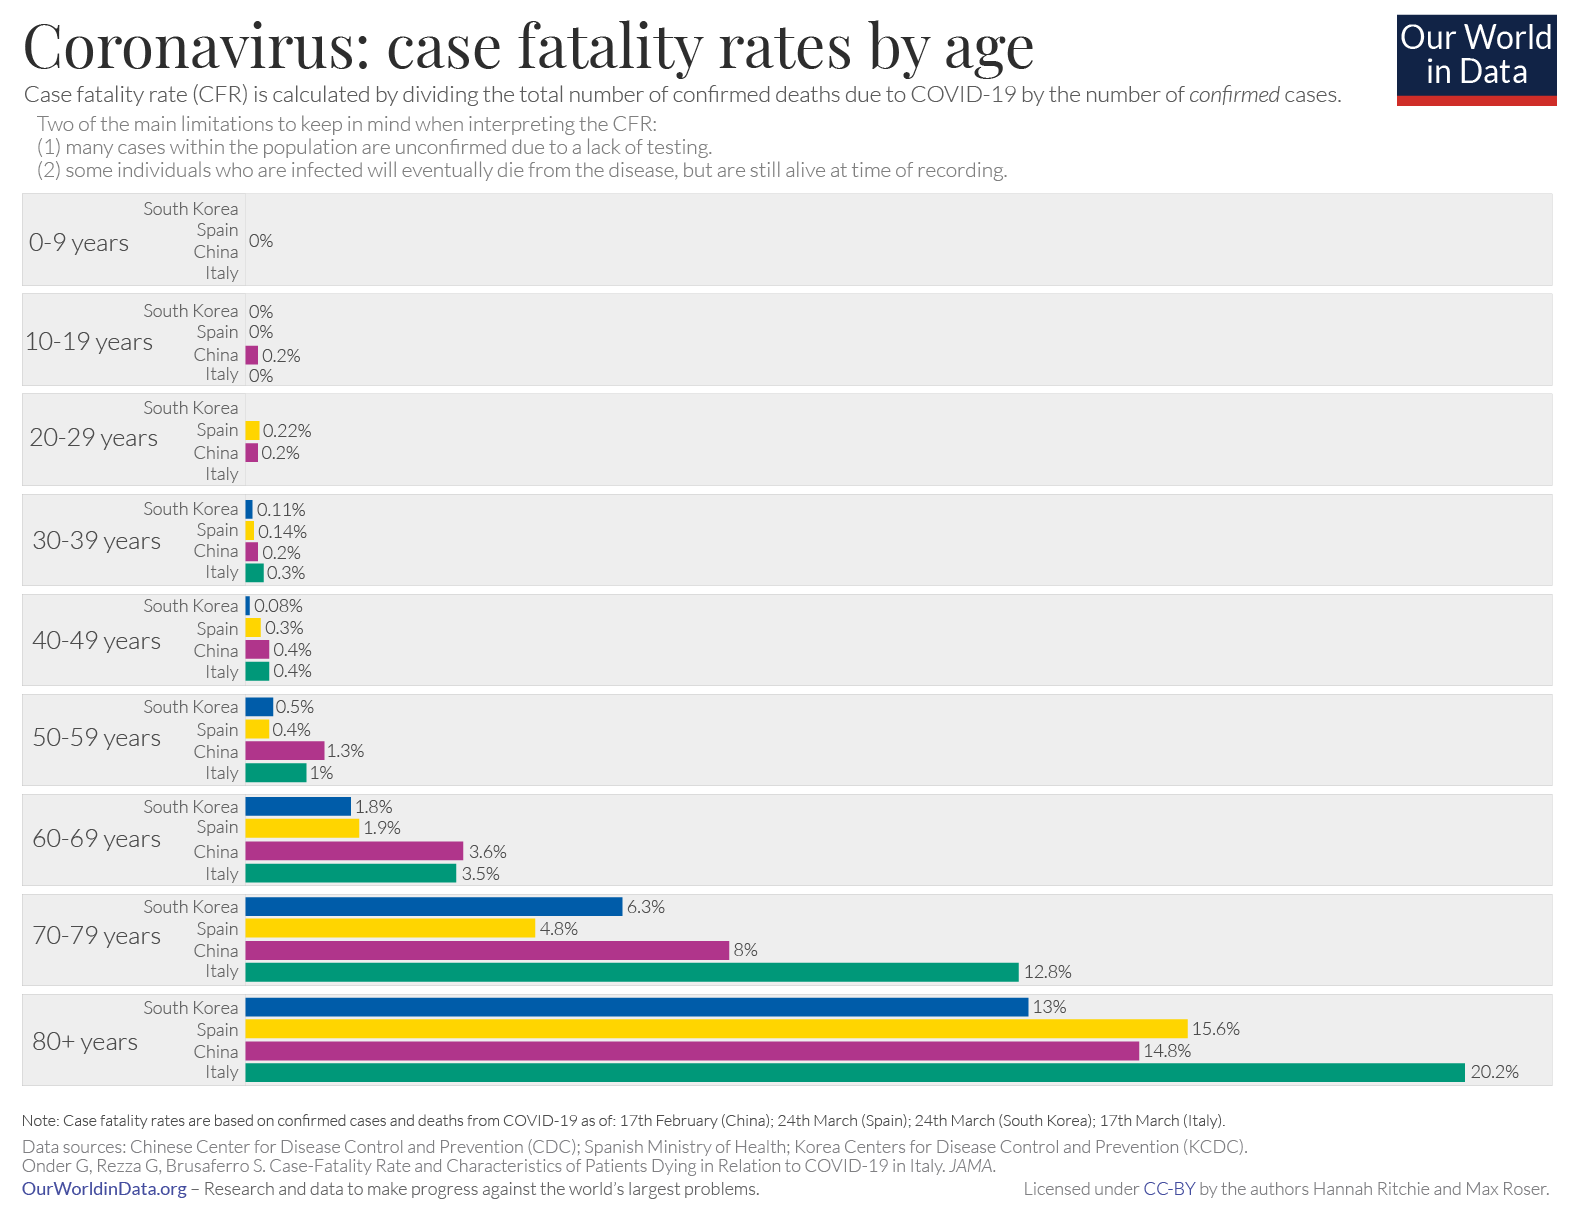

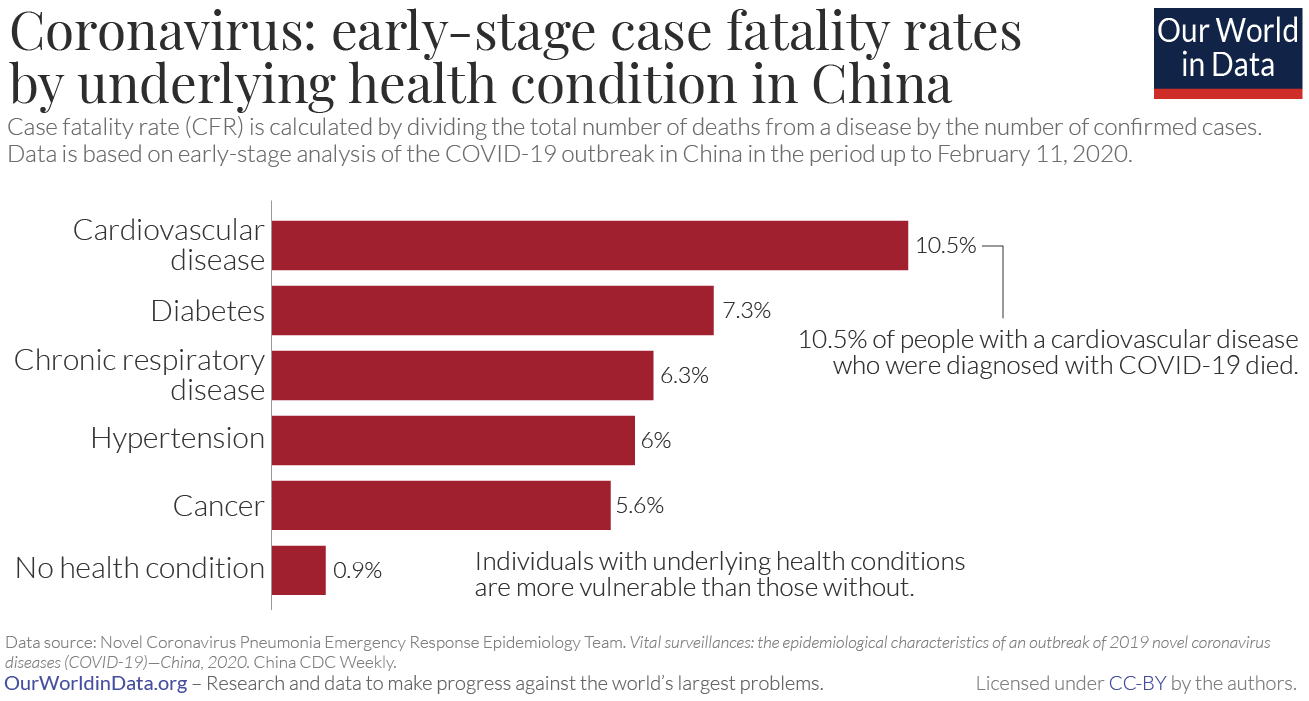

In [ ]:
sex_distr = covid_df_detailed['sex'].value_counts()
fig = px.pie(sex_distr,sex_distr.index, sex_distr, title="Gender distribution on confirmed cases globally")
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

In [ ]:
age_distr = handle_age(covid_df_detailed)
fig = px.pie(age_distr, age_distr.index, age_distr, title="Age distribution on confirmed cases globally")
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

In [ ]:
out = covid_df_detailed['symptoms'].str.split('[,;]\s+', expand=True).stack()
out[out.str.contains('fever', case=False, na=False)] = 'fever'
# out[out.str.contains('sore throat', case=False, na=False)] = 'sore throat'
# out[out.str.contains('fatigue', case=False, na=False)] = 'fatigue'
vc = out.str.lower().value_counts().loc[lambda x : x>1] 
fig = px.pie(vc, vc.index, vc, title="Symptom distribution on confirmed cases globally")
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

# References
* https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons/#data
* https://www.kaggle.com/parulpandey/wuhan-coronavirus-a-geographical-analysis/#data